In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### 1. Downloading and cleaning the data

In [2]:
# Downloading the Adjusted Close Prices of Nifty Commodities Index Stocks
raw = pd.read_csv('niftycomm.csv') # Taking the ticker symbols form the csv file
tickers = [ticker + '.NS' for ticker in raw['Symbol'].tolist()] # Adding '.NS' to the ticker symbols to download NSE data from Yahoo Finance
end_date = pd.to_datetime('2024-05-15')
start_date = end_date - pd.DateOffset(years=3)
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close'] # Downloading the Adjusted Close Prices of the stocks

[*********************100%%**********************]  30 of 30 completed


In [3]:
df = df.drop(columns = ['ADANIENSOL.NS']) # Dropping ADANIENSOL.NS as it has insufficient data points
df = df.ffill() # Filling missing values with the previous day's value
df.to_csv('niftycomm_adj_close_prices.csv') # Saving the data to a csv file

### 2. Getting the lognormal returns and the covariance matrix

In [4]:
# Calculating lognormal daily returns for all the stocks
daily_returns = np.log(df/df.shift(1)).dropna() # Dropping the first row as it will have NaN value
tickers = daily_returns.columns # Updating the tickers list as we have dropped ADANIENSOL.NS
daily_returns.to_csv('niftycomm_daily_returns.csv') # Saving the data to a csv file

# Creating the covariance matrix
cov_mat = daily_returns.cov()
cov_mat.to_csv('niftycomm_cov_matrix.csv') # Saving the data to a csv file

### 3. Expected return, volatility and the Sharpe functions

In [5]:
def expected_return(weights, daily_returns): # Function to calculate the returns
    return np.sum(daily_returns.mean() * weights) * 252 # Annualizing the returns (252 trading days in a year)

def expected_volatility(weights, cov_matrix): # Function to calculate the volatility
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) # Annualizing the volatility

def neg_sharpe(weights, cov_matrix, daily_returns, risk_free_rate): # Function to calculate the negative Sharpe ratio
    return -((expected_return(weights, daily_returns) - risk_free_rate) / expected_volatility(weights, cov_matrix))

In [6]:
risk_free_rate = 0.0425 # Risk-free rate taken from average long term US treasury bond yield, usually considered risk-free

### 4. Original portfolio

In [7]:
# Getting the Original Portfolio Weights
og_weights = raw['Weightage'].tolist() # Getting the weightage of the stocks from the csv file
og_weights.pop(1) # Removing the ADANIENSOL.NS weightage as we have dropped it for our portfolio since the data was not sufficient
og_weights = np.array(og_weights) # Converting the list to a numpy array

In [8]:
exp_return = expected_return(og_weights, daily_returns) # Calculating the expected return of the original portfolio
exp_volatility = expected_volatility(og_weights, cov_mat) # Calculating the expected volatility of the original portfolio
sharpe_ratio = (exp_return - risk_free_rate) / exp_volatility # Calculating the Sharpe ratio of the original portfolio

### 5. Minimum Variance & Markowitz Portfolio

I will use scipy.optimize.minimize to find the minimum variance portfolio and the Markowitz portfolio by minimizing the expected volatility and negative Sharpe ratio respectivly. I'll set the lower bound of the optimization to 0 as we are not holding short positions.

In [9]:
initial_weights = np.array([1/len(tickers)] * len(tickers)) # Initial weights for the optimization
bounds = [(0, 1)] * len(tickers) # Bounds for the weights, 0 implies no shorting allowed
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Constraints for the weights, that they should sum to 1

In [10]:
min_var = minimize(expected_volatility, initial_weights, args=(cov_mat), method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe = minimize(neg_sharpe, initial_weights, args=(cov_mat, daily_returns, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [11]:
mv_returns = expected_return(min_var.x, daily_returns) # Calculating the expected return of the minimum variance portfolio
mv_volatility = expected_volatility(min_var.x, cov_mat) # Calculating the expected volatility of the minimum variance portfolio
mv_sharpe_ratio = (mv_returns - risk_free_rate) / mv_volatility # Calculating the Sharpe ratio of the minimum variance portfolio

ms_returns = expected_return(max_sharpe.x, daily_returns) # Calculating the expected return of the maximum Sharpe ratio portfolio
ms_volatility = expected_volatility(max_sharpe.x, cov_mat) # Calculating the expected volatility of the maximum Sharpe ratio portfolio
ms_sharpe_ratio = (ms_returns - risk_free_rate) / ms_volatility # Calculating the Sharpe ratio of the maximum Sharpe ratio portfolio

### 6. Comparing the portfolios

In [12]:
pfs = pd.DataFrame({'Original Portfolio': [exp_return, exp_volatility, sharpe_ratio], 'Minimum Volatility Portfolio': [mv_returns, mv_volatility, mv_sharpe_ratio], 'Maximum Sharpe Ratio Portfolio': [ms_returns, ms_volatility, ms_sharpe_ratio]}, index=['Expected Return', 'Expected Volatility', 'Sharpe Ratio'])
pfs.T.to_csv('niftycomm_portfolios.csv') # Saving the data to a csv file
pfs.T

,Expected Return,Expected Volatility,Sharpe Ratio
Original Portfolio,0.239308,0.180091,1.092821
Minimum Volatility Portfolio,0.188943,0.143749,1.018743
Maximum Sharpe Ratio Portfolio,0.431423,0.203540,1.910798


### 7. Getting the Efficient Frontier and the Capital Market Line

In [13]:
# Creating the efficient frontier
ef_returns = np.linspace(0, 0.6, 6000)
ef_volatility = []
ef_sharpe = []
iteration = 0
for ret in ef_returns:
    iteration += 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'eq', 'fun': lambda weights: expected_return(weights, daily_returns) - ret})
    result = minimize(expected_volatility, initial_weights, args=(cov_mat), method='SLSQP', bounds=bounds, constraints=constraints)
    ef_volatility.append(expected_volatility(result.x, cov_mat))
    ef_sharpe.append(-neg_sharpe(result.x, cov_mat, daily_returns, risk_free_rate))
    print(f"Iteration: {iteration}/6000 finished...")
    

# Creating the Capital Market Line that is tangential to the Efficient Frontier at the Markowitz Portfolio
cml_x = np.linspace(0.1, 0.3, 3000)
cml_y = [risk_free_rate + (ms_returns - risk_free_rate) / ms_volatility * vol for vol in cml_x]

Iteration: 1/6000 finished...
Iteration: 2/6000 finished...
Iteration: 3/6000 finished...
Iteration: 4/6000 finished...
Iteration: 5/6000 finished...
Iteration: 6/6000 finished...
Iteration: 7/6000 finished...
Iteration: 8/6000 finished...
Iteration: 9/6000 finished...
Iteration: 10/6000 finished...
Iteration: 11/6000 finished...
Iteration: 12/6000 finished...
Iteration: 13/6000 finished...
Iteration: 14/6000 finished...
Iteration: 15/6000 finished...
Iteration: 16/6000 finished...
Iteration: 17/6000 finished...
Iteration: 18/6000 finished...
Iteration: 19/6000 finished...
Iteration: 20/6000 finished...
Iteration: 21/6000 finished...
Iteration: 22/6000 finished...
Iteration: 23/6000 finished...
Iteration: 24/6000 finished...
Iteration: 25/6000 finished...
Iteration: 26/6000 finished...
Iteration: 27/6000 finished...
Iteration: 28/6000 finished...
Iteration: 29/6000 finished...
Iteration: 30/6000 finished...
Iteration: 31/6000 finished...
Iteration: 32/6000 finished...
Iteration: 33/600

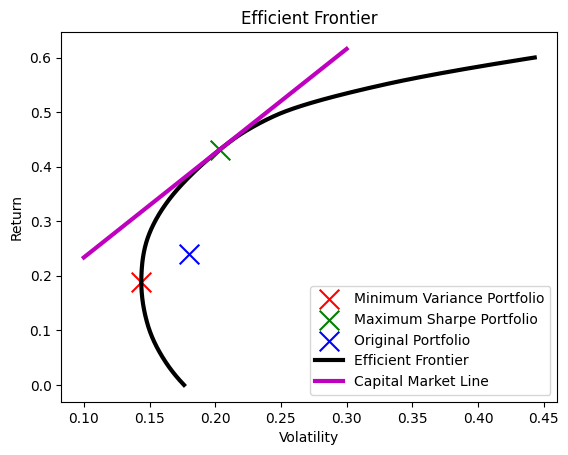

In [19]:
# Plotting the Efficient Frontier along with the Sharpe Gradient
plt.scatter(mv_volatility, mv_returns, c='r', marker='x', s=200) # Minimum Variance Portfolio
plt.scatter(ms_volatility, ms_returns, c='g', marker='x', s=200) # Maximum Sharpe Ratio Portfolio
plt.scatter(exp_volatility, exp_return, c='b', marker='x', s=200) # Original Portfolio
plt.plot(ef_volatility, ef_returns, 'black', linewidth=3)
plt.plot(cml_x, cml_y, 'm', linewidth=3)
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Plotting the Legend
plt.legend(['Minimum Variance Portfolio', 'Maximum Sharpe Portfolio', 'Original Portfolio', 'Efficient Frontier', 'Capital Market Line'])
plt.show()

In [22]:
# Creating a dataframe with the weights for the original, minimum variance and maximum Sharpe ratio portfolios
weights_df = pd.DataFrame({'Original Portfolio': og_weights, 'Minimum Variance Portfolio': min_var.x, 'Markowitz Portfolio': max_sharpe.x}, index=tickers)
weights_df.to_csv('niftycomm_weights.csv') # Saving the data to a csv file
weights_df

,Original Portfolio,Minimum Variance Portfolio,Markowitz Portfolio
ACC.NS,0.0075,2.364762e-17,2.361963e-16
ADANIGREEN.NS,0.0462,3.200219e-03,6.815891e-16
ADANIPOWER.NS,0.0395,0.000000e+00,9.547835e-02
AMBUJACEM.NS,0.0197,0.000000e+00,3.371182e-16
APLAPOLLO.NS,0.0071,3.608392e-02,9.470327e-02
BPCL.NS,0.0214,4.680594e-02,6.178727e-17
COALINDIA.NS,0.0451,0.000000e+00,2.072324e-01
DALBHARAT.NS,0.0054,0.000000e+00,6.946540e-16
DEEPAKNTR.NS,0.0055,0.000000e+00,1.054253e-16
GRASIM.NS,0.0258,0.000000e+00,0.000000e+00
